# Explainable AI

This workshop will focus on explaining the outcomes of a predictive analytics model.  
  
We provide similar explanation for two cases: 1) regression with Toyota Corolla Car Prices Dataset, and 2) classification with Titanic dataset.  

For each of the case study, we develop partial dependence plot (PDP), individual conditional expectation (ICE) plots and advance explanation using SHAP framework.

Install python library for partial dependence plot toolbox.  
Documentation URL: https://pdpbox.readthedocs.io/en/latest/

In [1]:
# Install python library for partial dependence plot toolbox
!pip install pdpbox 

     |████████████████████████████████| 57.7MB 63kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=b8409163f1ef736fe92ce923fe5a9e34dd998a0732abd4dcac5f7df78b83487f
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


Install python library for SHAP explainer toolbox.  
Documentation URL: https://shap.readthedocs.io/en/latest/

In [2]:
# Install python library for SHAP explainer toolbox
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394118 sha256=4c1ff02272aa4ffbb15f51c4ef4d950597ae0dcf1e4d7616517690721c291ae1
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


Install python library for LIME explainer toolbox.  
Documentation URL: https://github.com/marcotcr/lime

In [ ]:
!pip install lime

Load common libraries for data wrangling.

In [3]:
# Load required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection  import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

## Regression

Load the dataset file to a dataframe using Pandas library.

In [4]:
df = pd.read_csv('tp4_toyota_corolla.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1436 non-null   int64 
 1   Age        1436 non-null   int64 
 2   KM         1436 non-null   int64 
 3   FuelType   1436 non-null   object
 4   HP         1436 non-null   int64 
 5   MetColor   1436 non-null   int64 
 6   Automatic  1436 non-null   int64 
 7   CC         1436 non-null   int64 
 8   Doors      1436 non-null   int64 
 9   Weight     1436 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 112.3+ KB


**Data Description**
* Price: Price in EUROs  
* Age: Age in years  
* KM: Accumulated Kilometers on odometer  
* FuelType: Fuel Type (Petrol, Diesel, CNG)  
* HP: Horse Power  
* MetColor: Metallic Color? (Yes=1, No=0)  
* Automatic: Automatic ( (Yes=1, No=0)  
* CC: Cylinder Volume in cubic centimeters  
* Doors: Number of doors  
* Weight: Weight in Kilograms  

In [6]:
df.head()

Price  Age     KM FuelType  HP  MetColor  Automatic    CC  Doors  Weight
0  13500   23  46986   Diesel  90         1          0  2000      3    1165
1  13750   23  72937   Diesel  90         1          0  2000      3    1165
2  13950   24  41711   Diesel  90         1          0  2000      3    1165
3  14950   26  48000   Diesel  90         0          0  2000      3    1165
4  13750   30  38500   Diesel  90         0          0  2000      3    1170

The dataset contains one categorical variable (FuelType). For the demonstration we will ignore this column.   
Exercise: Recall 'Categorical variable transformation' techniques you learned for BUS5PA. Transofrm FuelType variable and run the experiment again. Evaluate if you can improve the accuracy.

In [7]:
# Setup train and test data
df_x = df[['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight']]
df_y = df[['Price']]

This dataset contains 506 data points. Therefore, we could select data split as train/validation as 70/30 (we will not be using test data split)

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(df_x, df_y, test_size = 0.3, random_state = 5)

### Modeling

Train a simple linear regression model

In [9]:
from sklearn import linear_model

# Model
reg_model = linear_model.LinearRegression()
reg_model.fit(X_train,Y_train)

# Predict
Y_val_predict = reg_model.predict(X_val)

# Evaluate
error_val = np.sqrt(mean_squared_error(Y_val_predict, Y_val))
print('Validation Root Mean Squared Error (Linear regression): ' + str(error_val))

Validation Root Mean Squared Error (Linear regression): 1306.5645389387587


Train an advanced Gradient boosting regression model

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, Y_train)

# Predict
Y_val_predict = gbr_model.predict(X_val)

# Evaluate
error_val = np.sqrt(mean_squared_error(Y_val_predict, Y_val))
print('Validation Root Mean Squared Error (Gradient Boosting): ' + str(error_val))

Validation Root Mean Squared Error (Gradient Boosting): 1035.0763515052163


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Partial Dependence Plots

The following function is created for the convinience to generate PDP plots and ICE plots

In [12]:
from pdpbox import pdp
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


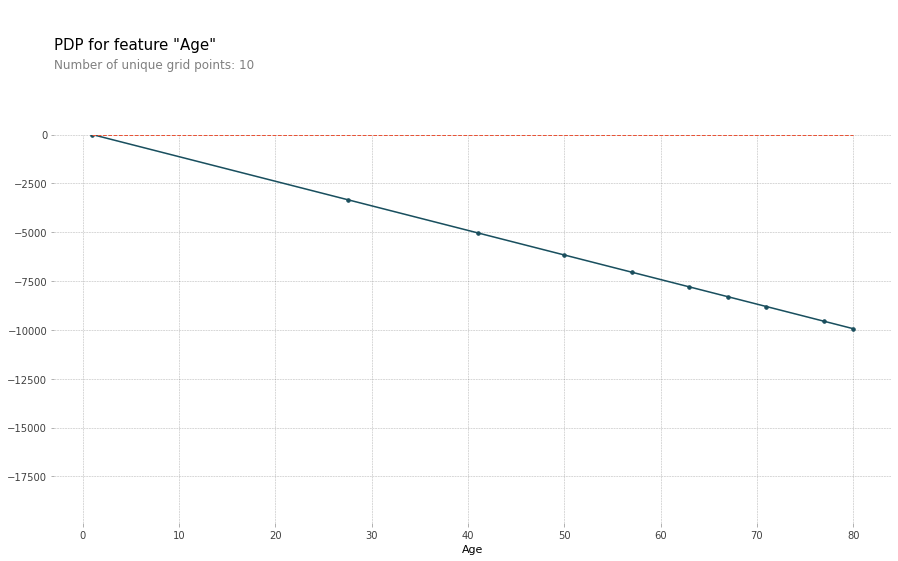

In [13]:
# plot the PD univariate plot with linear regression
plot_pdp(reg_model, X_train, 'Age')

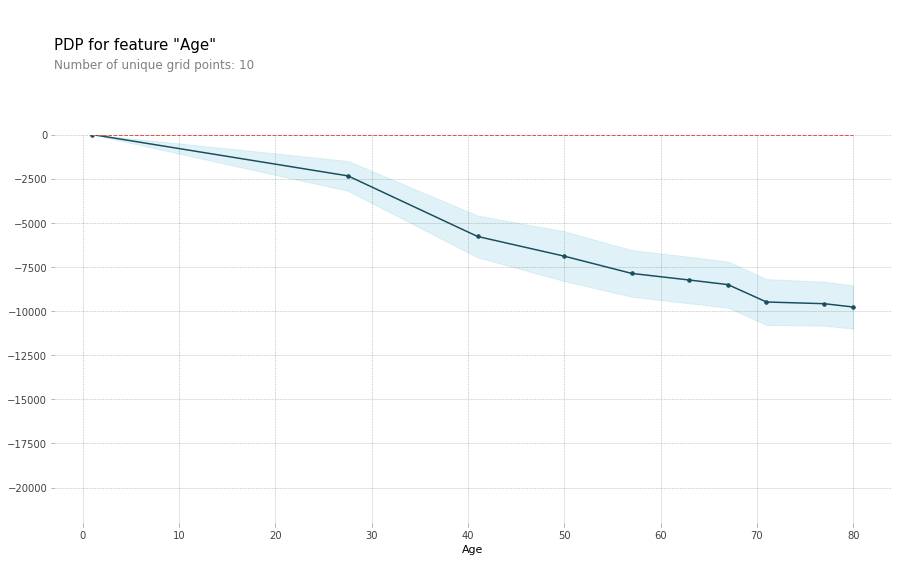

In [14]:
# plot the PD univariate plot with gradient boosting
plot_pdp(gbr_model, X_train, 'Age')

The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model. A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. For example, when applied to a linear regression model, partial dependence plots always show a linear relationship.

You selected Automatic


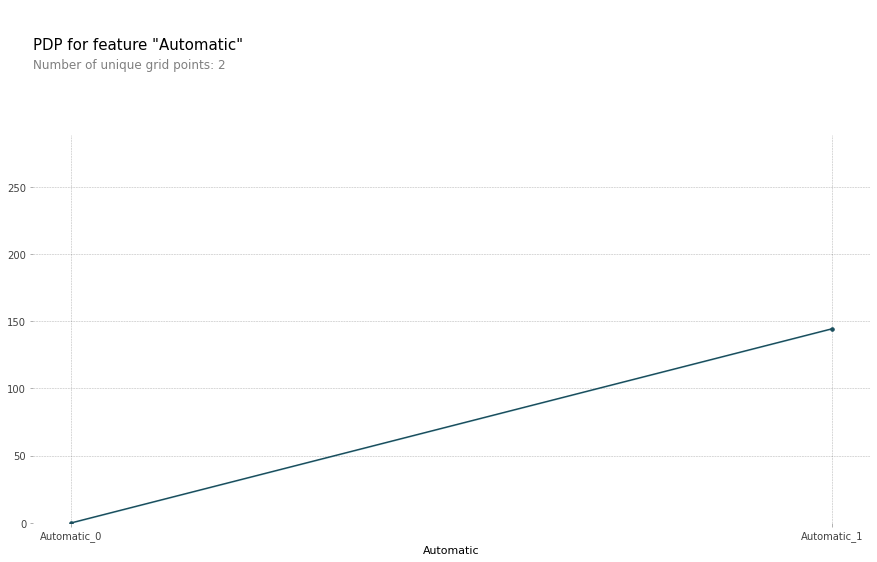

In [15]:
#@title Select a predictor to analyse Linear Regression Model. { run: "auto" }

selected_predictor = "Automatic" #@param ['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight']
print('You selected', selected_predictor)
plot_pdp(reg_model, X_train, selected_predictor)

You selected KM


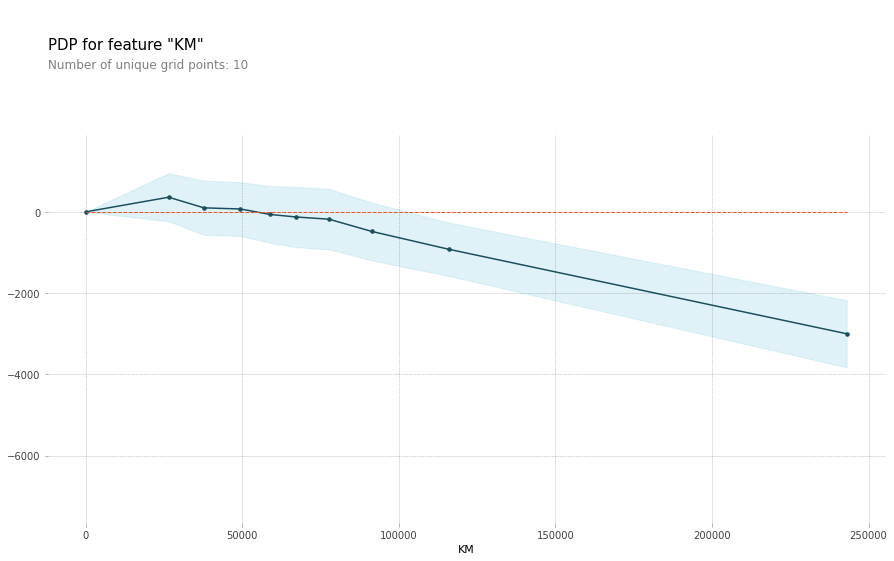

In [16]:
#@title Select a predictor to analyse Gradient Boosting Model. { run: "auto" }

selected_predictor = "KM" #@param ['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight']
print('You selected', selected_predictor)
plot_pdp(gbr_model, X_train, selected_predictor)

ICE Plots

ICE plot visualizes the dependence of the prediction on a feature for each instance (or clusters of instances) separately, resulting in one line per instance (or cluster), compared to one line overall in partial dependence plots.

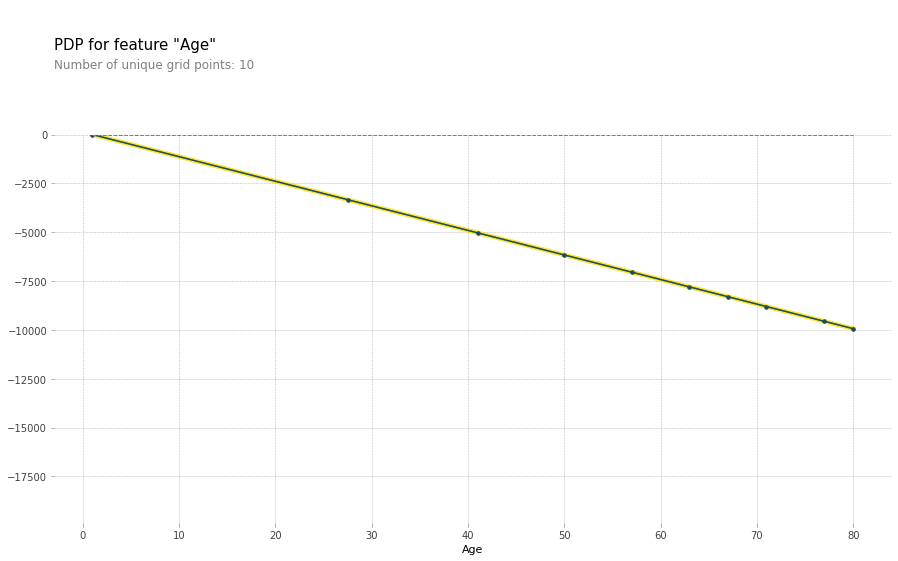

In [17]:
# ICE Plot with linear regression
plot_pdp(reg_model, X_train, 'Age', cluster_flag=True, nb_clusters=10, lines_flag=True)

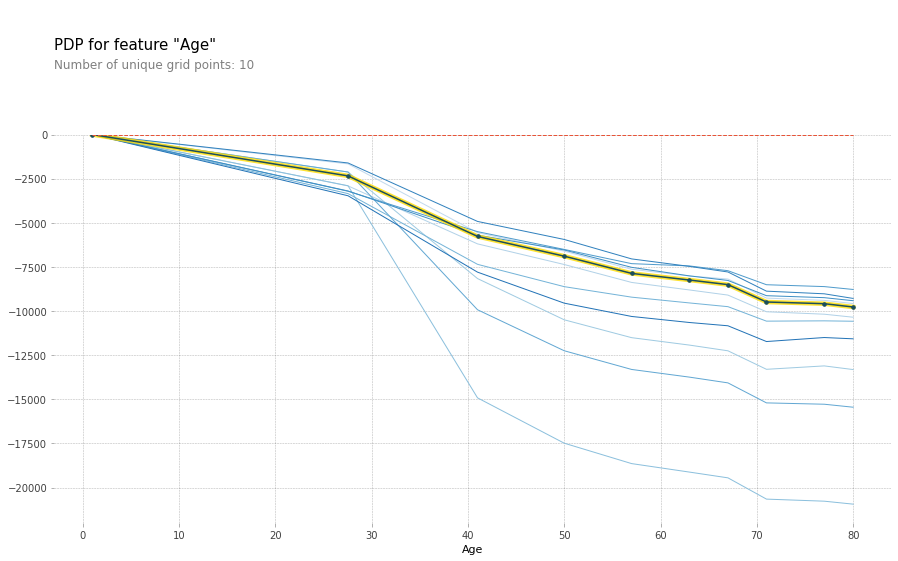

In [18]:
# ICE Plot with gradient boosting
plot_pdp(gbr_model, X_train, 'Age', cluster_flag=True, nb_clusters=10, lines_flag=True)

You selected KM with 20 clusters.


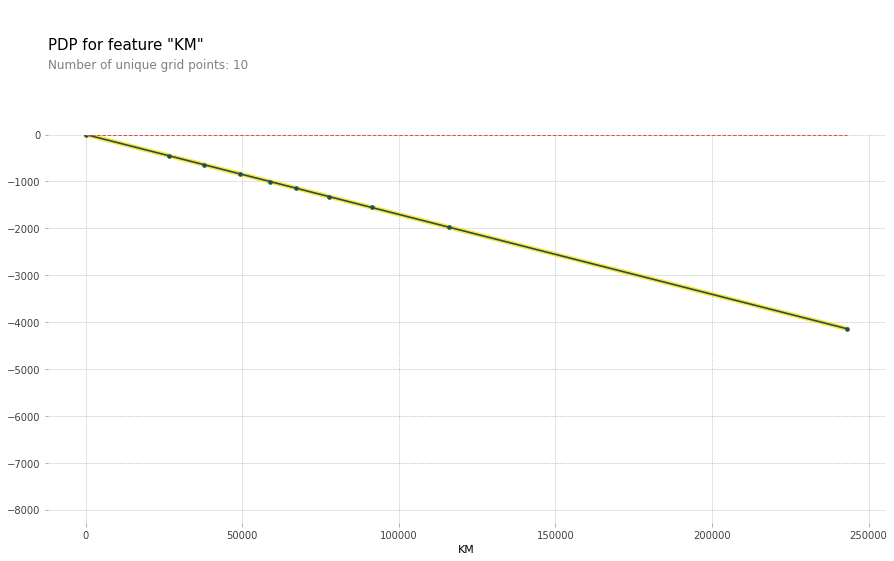

In [19]:
#@title Select a predictor to analyse Linear Regression Model. { run: "auto" }

selected_predictor = "KM" #@param ['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight']
number_clusters = 20 #@param {type:"slider", min:1, max:50, step:1}
print('You selected {} with {} clusters.'.format(selected_predictor, number_clusters))
plot_pdp(reg_model, X_train, selected_predictor, cluster_flag=True, nb_clusters=number_clusters, lines_flag=True)

You selected Automatic with 49 clusters.


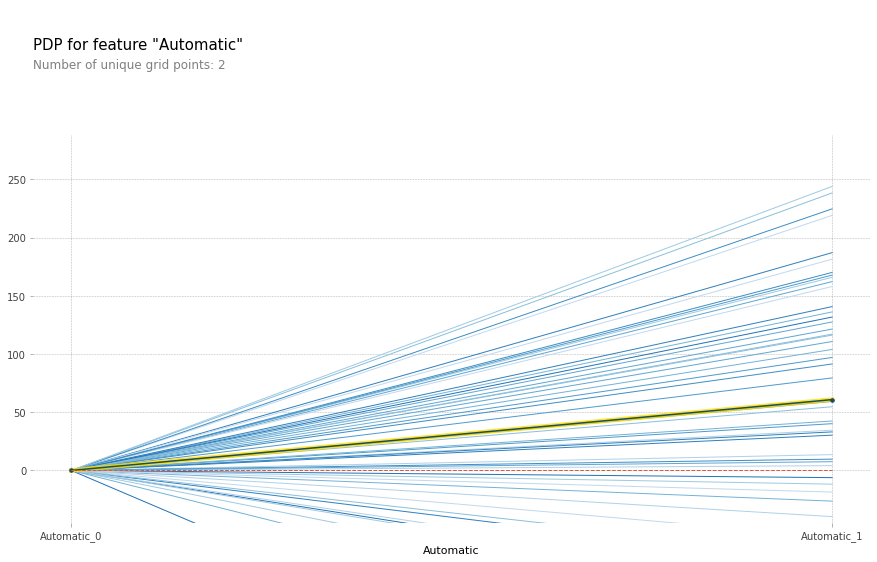

In [20]:
#@title Select a predictor to analyse Gradient Boosting Model. { run: "auto" }

selected_predictor = "Automatic" #@param ['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight']
number_clusters = 49 #@param {type:"slider", min:1, max:50, step:1}
print('You selected {} with {} clusters.'.format(selected_predictor, number_clusters))
plot_pdp(gbr_model, X_train, selected_predictor, cluster_flag=True, nb_clusters=number_clusters, lines_flag=True)

### SHAP Explainer

In [21]:
# import shap library
import shap

Create a shap explainer from gradient boosting model

In [22]:
explainer = shap.TreeExplainer(gbr_model)
shap_values = explainer.shap_values(X_train)

Explain individual train (or test) data points on their contribution to the outcome.  
The below visualization shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

In [23]:
record_id = 73

print('Actual values:')
print(X_train.iloc[record_id,:])

# Looks like Google Colab needs shap.initjs() in every cell where there is a visualization.
shap.initjs()

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[record_id,:], X_train.iloc[record_id,:])

Actual values:
Age             42
KM           61300
HP              97
MetColor         1
Automatic        0
CC            1400
Doors            3
Weight        1030
Name: 232, dtype: int64


If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [24]:
# Looks like Google Colab needs shap.initjs() in every cell where there is a visualization.
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_train)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high LSTAT (% lower status of the population) lowers the predicted home price.

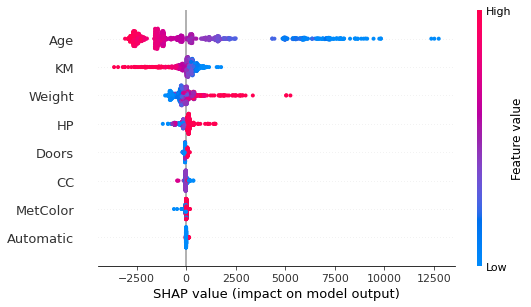

In [25]:
# summarize the effects of all the features
shap.initjs()
shap.summary_plot(shap_values, X_train)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs).

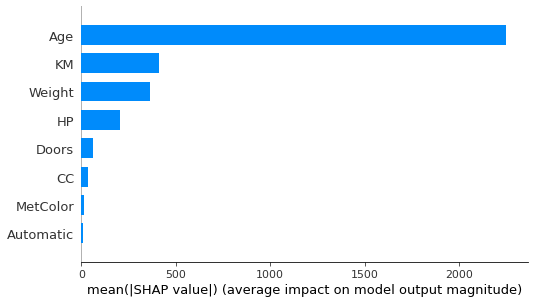

In [26]:
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type="bar")

## Classification

In [ ]:
# Load the dataset directly
df_titanic = pd.read_csv('tp3_titanic_data.csv')  # Load the dataset

In [ ]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


For this tutorial we only consider integer/numeric predictors for explanation.  
Exercise: You are expected to conduct feature engineering as we demonstrated in tutorial 3, and redo the XAI as follows.

In [ ]:
df_titanic_x = df_titanic[['Pclass', 'Age', 'Fare', 'SibSp']]
df_titanic_y = df_titanic[['Survived']]

In [ ]:
# Fill missing values in Age
df_titanic_x['Age'].fillna((df_titanic_x['Age'].mean()), inplace=True)

In [ ]:
X_titanic_train, X_titanic_val, Y_titanic_train, Y_titanic_val = train_test_split(df_titanic_x, df_titanic_y, test_size = 0.3, random_state = 5)

### Modeling 

We will model a simple logistic regression as the initial step.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Modeling
gbc_model = GradientBoostingClassifier()
gbc_model.fit(X_titanic_train,Y_titanic_train)

# Classification
Y_titanic_val_predict = gbc_model.predict(X_titanic_val)

# Evaluate
accuracy = accuracy_score(Y_titanic_val_predict, Y_titanic_val)
print('Accuracy: ' + str(accuracy))

Accuracy: 0.6865671641791045


### PDP and ICE plots

In [ ]:
from pdpbox import pdp
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)

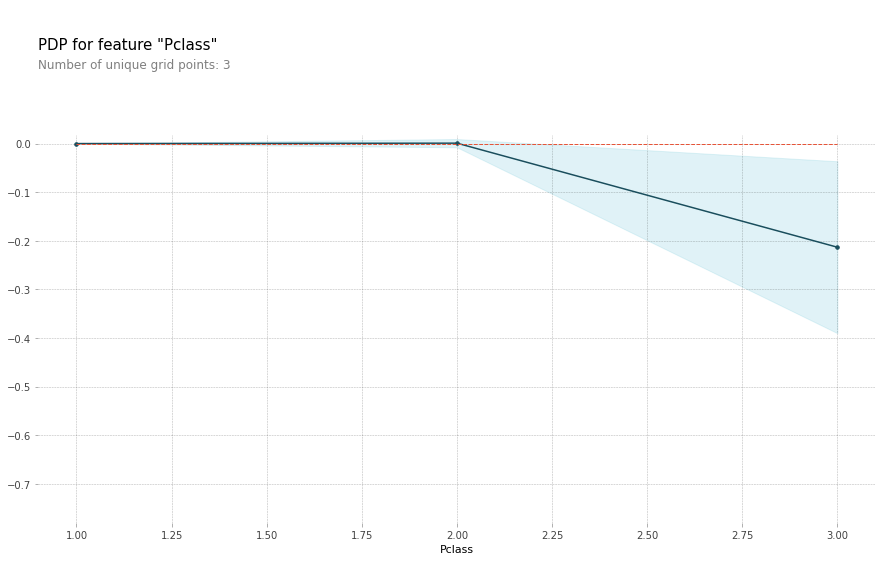

In [ ]:
# plot the PD univariate plot with linear regression
plot_pdp(gbc_model, X_titanic_train, 'Pclass')

You selected Age


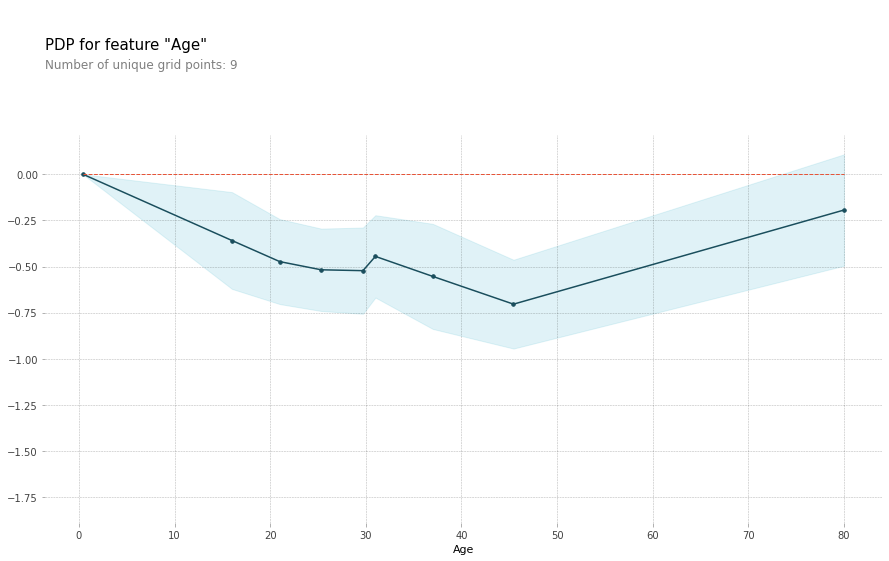

In [ ]:
#@title Select a predictor to analyse PDP { run: "auto" }

selected_predictor = "Age" #@param ['Pclass', 'Age', 'Fare', 'SibSp']
print('You selected', selected_predictor)
plot_pdp(gbc_model, X_titanic_train, selected_predictor)

You selected SibSp with 13 clusters.


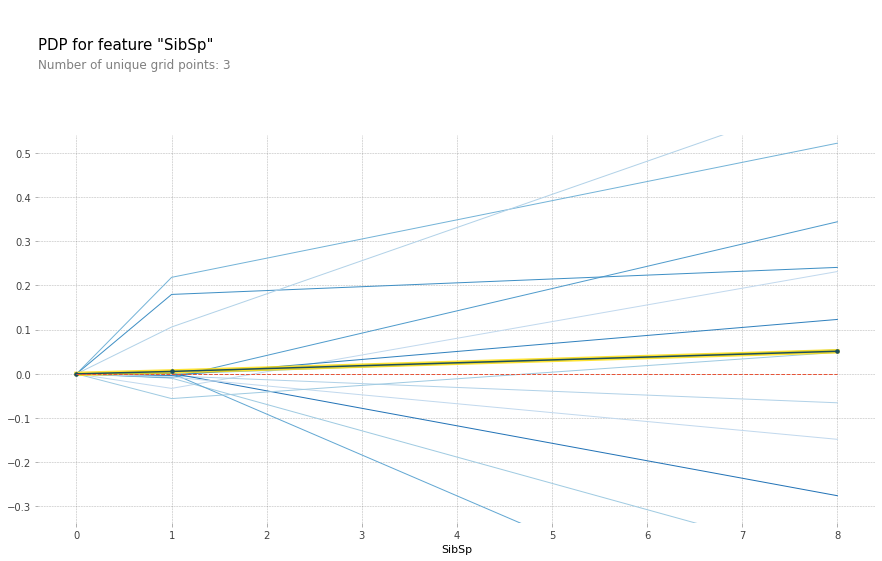

In [ ]:
#@title Select a predictor to analyse ICE { run: "auto" }

selected_predictor = "SibSp" #@param ['Pclass', 'Age', 'Fare', 'SibSp']
number_clusters = 13 #@param {type:"slider", min:1, max:50, step:1}
print('You selected {} with {} clusters.'.format(selected_predictor, number_clusters))
plot_pdp(gbc_model, X_titanic_train, selected_predictor, cluster_flag=True, nb_clusters=number_clusters, lines_flag=True)

### SHAP Explainer

In [ ]:
import shap

Create a shap explainer from gradient boosting model

In [ ]:
explainer = shap.TreeExplainer(gbc_model)
shap_values = explainer.shap_values(X_titanic_train)

Explain individual test data points on their contribution to the outcome.  
The below visualization shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

In [ ]:
record_id = 2

print('Actual values:')
print(X_titanic_train.iloc[record_id,:])

# Looks like Google Colab needs shap.initjs() in every cell where there is a visualization.
shap.initjs()

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[record_id,:], X_titanic_train.iloc[record_id,:])

Actual values:
Pclass     2.0
Age       34.0
Fare      13.0
SibSp      0.0
Name: 21, dtype: float64


If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [ ]:
# Looks like Google Colab needs shap.initjs() in every cell where there is a visualization.
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_titanic_train)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.

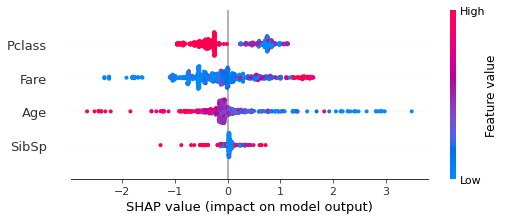

In [ ]:
# summarize the effects of all the features
shap.initjs()
shap.summary_plot(shap_values, X_titanic_train)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs).

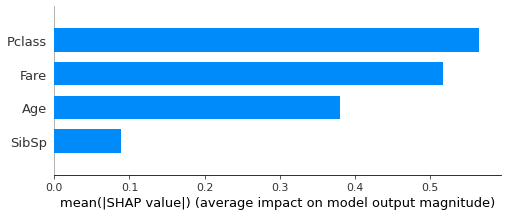

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_titanic_train, plot_type="bar")